# EDA Analysis of images (COLOR) of cancers and creation of train, val and test sets.

In [14]:
#Import all the libraries needed in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import shutil
import random
import tensorflow as tf
import torch
#import statsmodels.api as sm

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
'''# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Import tensorflow libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
'''
#Import torch libraries
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [20]:
# Define the path of the image folders
benign_path = 'benign_color/'
malignant_path = 'malignant_color/'

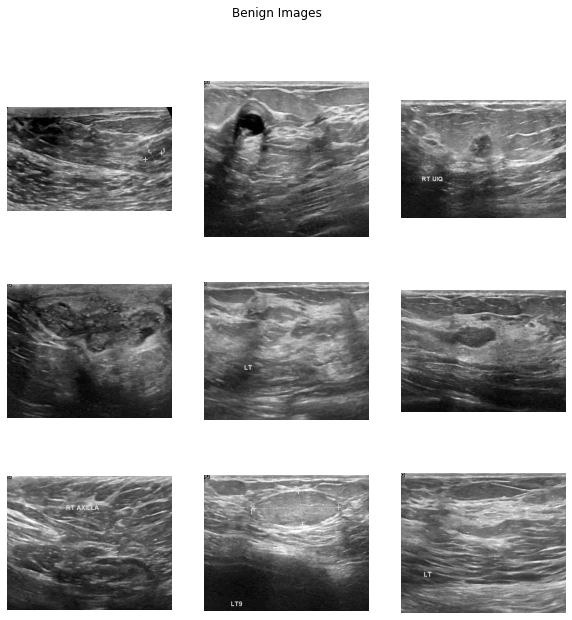

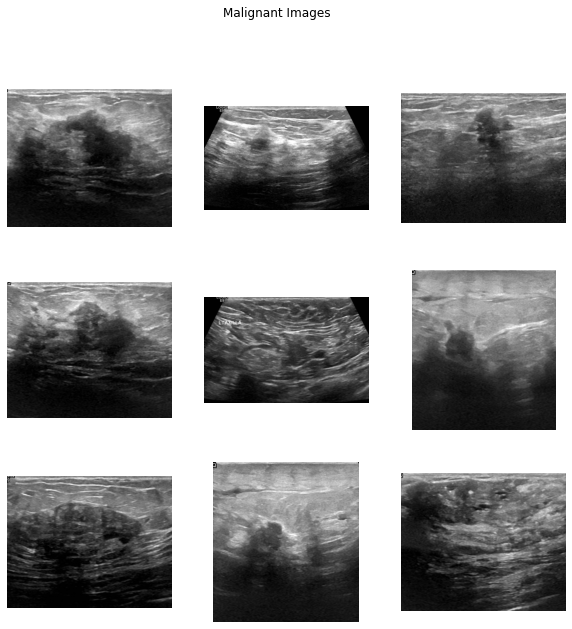

In [21]:
# Get the list of files in the folders
benign_images = os.listdir(benign_dir)
malignant_images = os.listdir(malignant_dir)

# Display the first 9 benign images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(benign_dir, benign_images[i])
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Benign Images')
plt.show()

# Display the first 9 malignant images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(malignant_dir, malignant_images[i])
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Malignant Images')
plt.show()

In [22]:
def image_size_statistics(folder_path):
    heights = []
    widths = []
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        height, width, _ = image.shape
        heights.append(height)
        widths.append(width)
    return heights, widths

In [23]:
# Bening images' statistics
benign_heights, benign_widths = image_size_statistics(benign_path)
num_benign_images = len(benign_heights)
print("Statistiche dimensioni tumori benigni:")
print(f"Numero totale di immagini: {num_benign_images}")
print(f"Dimensioni medie (altezza x larghezza): {sum(benign_heights) / num_benign_images} x {sum(benign_widths) / num_benign_images}")
print(f"Dimensioni minime (altezza x larghezza): {min(benign_heights)} x {min(benign_widths)}")
print(f"Dimensioni massime (altezza x larghezza): {max(benign_heights)} x {max(benign_widths)}")

Statistiche dimensioni tumori benigni:
Numero totale di immagini: 437
Dimensioni medie (altezza x larghezza): 495.47139588100686 x 613.3867276887872
Dimensioni minime (altezza x larghezza): 324 x 315
Dimensioni massime (altezza x larghezza): 719 x 1028


In [24]:
# Malignant images' statistics
malignant_heights, malignant_widths = image_size_statistics(malignant_path)
num_malignant_images = len(malignant_heights)
print("\nStatistiche dimensioni tumori maligni:")
print(f"Numero totale di immagini: {num_malignant_images}")
print(f"Dimensioni medie (altezza x larghezza): {sum(malignant_heights) / num_malignant_images} x {sum(malignant_widths) / num_malignant_images}")
print(f"Dimensioni minime (altezza x larghezza): {min(malignant_heights)} x {min(malignant_widths)}")
print(f"Dimensioni massime (altezza x larghezza): {max(malignant_heights)} x {max(malignant_widths)}")


Statistiche dimensioni tumori maligni:
Numero totale di immagini: 122
Dimensioni medie (altezza x larghezza): 480.172131147541 x 576.8934426229508
Dimensioni minime (altezza x larghezza): 335 x 190
Dimensioni massime (altezza x larghezza): 616 x 795


## Creating the folders and the new datasets

In [33]:
# Define input and output folder paths
input_benign_path = "benign_color"
input_malignant_path = "malignant_color"
output_train_path = "dataset/train/"
output_val_path = "dataset/val/"
output_test_path = "dataset/test/"

In [34]:
# Create output folders
os.makedirs(output_train_path, exist_ok=True)
os.makedirs(output_val_path, exist_ok=True)
os.makedirs(output_test_path, exist_ok=True)

In [35]:
# Defining the dataset proportion (e.g., 70% train, 15% validation, 15% test)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [36]:
# Function to copy images from the input folder to the output folder
def copy_images(input_path, output_path, file_list):
    os.makedirs(output_path, exist_ok=True)
    for file_name in file_list:
        shutil.copy(os.path.join(input_path, file_name), output_path)

In [37]:
# Get the list of files for benign and malignant tumors
benign_color = os.listdir(input_benign_path)
malignant_color = os.listdir(input_malignant_path)

In [38]:
# Shuffle the lists of images randomly
random.shuffle(benign_color)
random.shuffle(malignant_color)

In [39]:
# Dataset's dimensions
num_train_benign = int(len(benign_color) * train_ratio)
num_val_benign = int(len(benign_color) * val_ratio)
num_test_benign = len(benign_color) - num_train_benign - num_val_benign
num_train_malignant = int(len(malignant_color) * train_ratio)
num_val_malignant = int(len(malignant_color) * val_ratio)
num_test_malignant = len(malignant_color) - num_train_malignant - num_val_malignant

In [40]:
# Copying images in folders
copy_images(input_benign_path, os.path.join(output_train_path, "benign"), benign_images[:num_train_benign])
copy_images(input_benign_path, os.path.join(output_val_path, "benign"), benign_images[num_train_benign:num_train_benign + num_val_benign])
copy_images(input_benign_path, os.path.join(output_test_path, "benign"), benign_images[-num_test_benign:])
copy_images(input_malignant_path, os.path.join(output_train_path, "malignant"), malignant_images[:num_train_malignant])
copy_images(input_malignant_path, os.path.join(output_val_path, "malignant"), malignant_images[num_train_malignant:num_train_malignant + num_val_malignant])
copy_images(input_malignant_path, os.path.join(output_test_path, "malignant"), malignant_images[-num_test_malignant:])